In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import logging

In [2]:
import torch
from torch.distributions import constraints
from torch import nn

In [3]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import pyro.distributions as dist

from pyro.nn import PyroModule
from pyro.nn import PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal,AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

# pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.4')

In [4]:
logging.basicConfig(format='%(message)s', level=logging.INFO)

### data setup

In [5]:
real_estate = pd.read_excel("./Real estate valuation data set.xlsx",index_col=0)

X = real_estate[["X2 house age","X3 distance to the nearest MRT station"]]
y = np.log(real_estate["Y house price of unit area"])

In [6]:
x_data = torch.tensor(X.values, dtype=torch.float)
y_data = torch.tensor(y.values, dtype=torch.float)

### Write the model

In [7]:
class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(-0.001, 0.25).expand([out_features, in_features]\
                                                                         ).to_event(out_features))
        self.linear.bias = PyroSample(dist.Normal(4.0, 0.25).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.0))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [8]:
br_model = BayesianRegression(X.shape[1], 1)

#### Sample with SVI Multivariate Diagonal

In [9]:
num_iters = 10000
guide = AutoDiagonalNormal(br_model)

adam = pyro.optim.Adam({"lr": 0.08})
svi = SVI(br_model, guide, adam, loss=Trace_ELBO())

pyro.clear_param_store()
# num_iters = 5000 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(x_data,y_data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 75314258.88766766
Elbo loss: 250590.90934157372
Elbo loss: 38983.08322918415
Elbo loss: 10774.455777287483
Elbo loss: 455.3463807106018
Elbo loss: 4768.570606589317
Elbo loss: 684.7389101982117
Elbo loss: 618.2663840055466
Elbo loss: 379.8931565284729
Elbo loss: 732.2439025640488
Elbo loss: 10257.800167441368
Elbo loss: 9129.45354783535
Elbo loss: 10630.173372983932
Elbo loss: 813.5397080183029
Elbo loss: 2387.232000350952
Elbo loss: 3423.518300294876
Elbo loss: 397.1708301305771
Elbo loss: 7587.877986073494
Elbo loss: 573.437042593956
Elbo loss: 875.8681670427322


In [10]:
from pyro.infer import Predictive


num_samples = 250
predictive = Predictive(br_model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(v.shape[0],v.shape[-1]).detach().cpu().numpy()
               for k, v in predictive(x_data).items()
               if k != "obs"}

In [11]:
svi_samples.keys()

dict_keys(['sigma', 'linear.weight', 'linear.bias'])

In [12]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

pred_summary = summary(svi_samples)

In [13]:
param_diagonal = pd.DataFrame()
for key, val_torch in svi_samples.items():
    val_np = val_torch
    if "linear" in key or "sigma" in key:
        param_diagonal[[f"{key}_{i}" for i in range(val_np.shape[1])]] = val_np

In [14]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.978245  0.002035  0.974827  0.976945  0.978241  0.979499  0.981689 

Site: linear.weight
       mean       std        5%       25%       50%       75%      95%
0 -0.008766  0.003678 -0.014392 -0.011151 -0.008724 -0.006106 -0.00295
1 -0.005127  0.000361 -0.005665 -0.005376 -0.005123 -0.004889 -0.00456 

Site: linear.bias
       mean       std        5%       25%       50%       75%       95%
0  3.924046  0.032608  3.869797  3.902092  3.925641  3.945324  3.979386 



### SVI MultivariateNormal Guide

In [15]:
guide = AutoMultivariateNormal(br_model, init_loc_fn=init_to_mean)

num_iters = 10000
svi = SVI(br_model, 
          guide, 
          optim.Adam({"lr": 0.1}), 
          loss=Trace_ELBO())

pyro.clear_param_store()
for i in range(num_iters):
    elbo = svi.step(x_data,y_data)
    if i % 500 == 0:
        print("Elbo loss: {}".format(elbo))

Elbo loss: 5303870.333131194
Elbo loss: 1497.417354941368
Elbo loss: 2323.268122434616
Elbo loss: 3949.8174386024475
Elbo loss: 1300.9100128412247
Elbo loss: 3667.9637888669968
Elbo loss: 36221.03389644623
Elbo loss: 558.7877327203751
Elbo loss: 3225.4059661626816
Elbo loss: 2015.0895055532455
Elbo loss: 26358.479775726795
Elbo loss: 1269.5957230329514
Elbo loss: 6485.611857295036
Elbo loss: 587.0991832017899
Elbo loss: 8031.946938872337
Elbo loss: 5880.125851988792
Elbo loss: 4255.546622276306
Elbo loss: 27607.84455525875
Elbo loss: 720.7149934768677
Elbo loss: 1488.9746980667114


In [16]:
predictive = Predictive(br_model, guide=guide, num_samples=num_samples)
svi_mvn_samples = {k: v.reshape(v.shape[0],v.shape[-1]).detach().cpu().numpy()
               for k, v in predictive(x_data).items()
               if k != "obs"}

In [17]:
param_mvn = pd.DataFrame()
for key, val_torch in svi_mvn_samples.items():
    val_np = val_torch
    if "linear" in key or "sigma" in key:
        param_mvn[[f"{key}_{i}" for i in range(val_np.shape[1])]] = val_np

In [18]:
import seaborn as sns

/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_36543/762335824.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(param_mvn[site], ax=ax, label="SVI (Multivariate Normal)")
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_36543/762335824.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

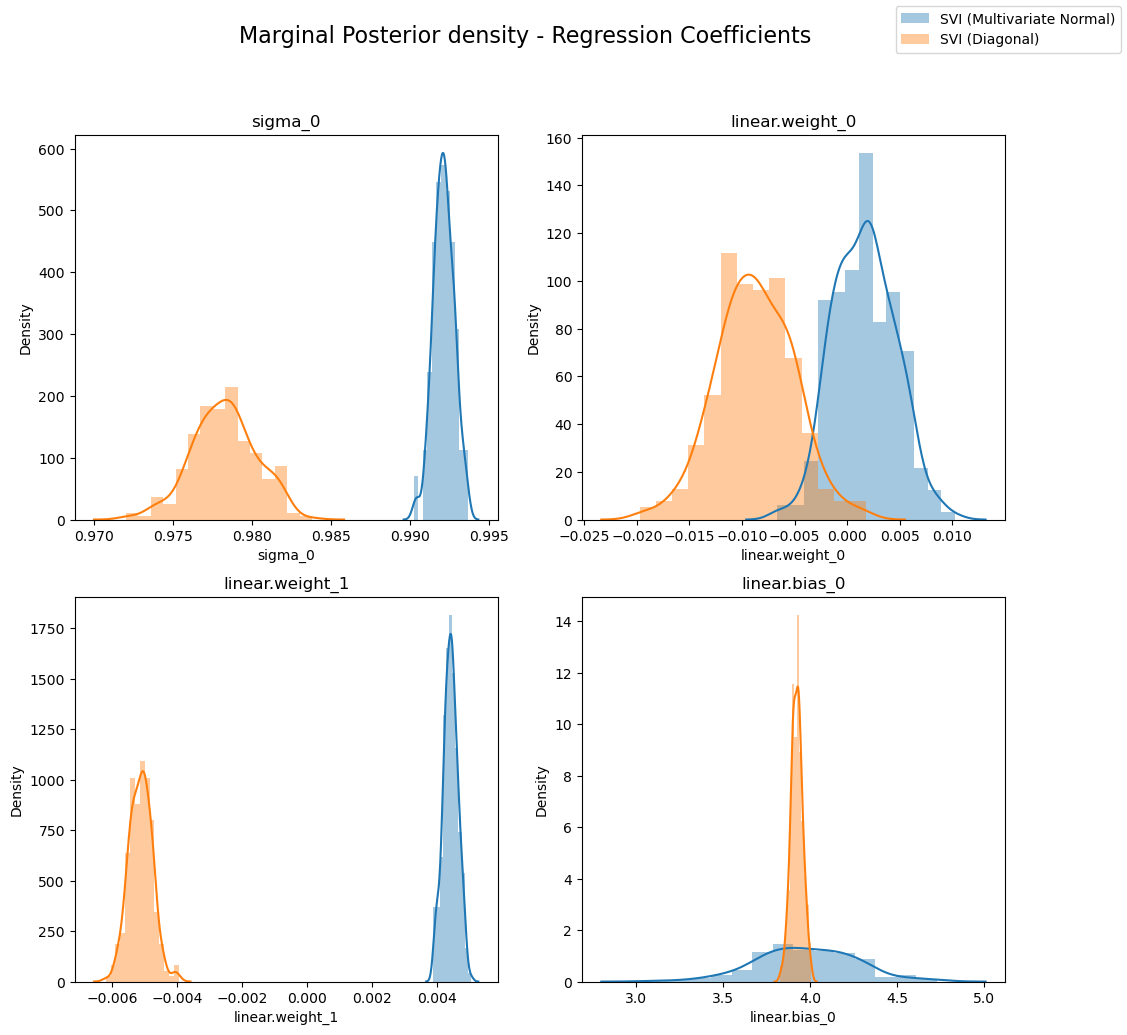

In [41]:
n_vars = X.shape[1]+2
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5*int(n_vars/2)+1))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)

for i, ax in enumerate(axs.reshape(-1)):
    if i<len(param_mvn.columns):
        site = param_mvn.columns[i]
        sns.distplot(param_mvn[site], ax=ax, label="SVI (Multivariate Normal)")
        sns.distplot(param_diagonal[site], ax=ax, label="SVI (Diagonal)")
        ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [20]:
svi_samples.keys()

dict_keys(['sigma', 'linear.weight', 'linear.bias'])

### HMC

In [21]:
from pyro.infer import MCMC, NUTS


nuts_kernel = NUTS(br_model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(x_data,y_data)

Sample: 100%|████████████████████████████████████████| 1200/1200 [12:25,  1.61it/s, step size=6.39e-04, acc. prob=0.977]                                                       


In [23]:
hmc_samples={}
for k, v in mcmc.get_samples().items():
    if "linear" in k:
        hmc_samples[k] = v.reshape(v.shape[0],v.shape[-1]).detach().cpu().numpy()
    else:
        hmc_samples[k] = v.detach().cpu().numpy()

In [24]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: linear.bias
       mean      std        5%       25%       50%       75%       95%
0  1.012069  0.46782  0.677699  0.680266  0.686701  1.287437  1.987149 

Site: linear.weight
       mean       std        5%       25%       50%       75%       95%
0  0.193938  0.136660  0.058234  0.080874  0.100486  0.327670  0.498802
1 -0.000505  0.000859 -0.002533 -0.001311  0.000054  0.000185  0.000272 

Site: sigma
       mean       std        5%       25%       50%       75%       95%
0  0.381255  0.141639  0.260661  0.269488  0.278907  0.513941  0.637569 



In [25]:
param_hmc = pd.DataFrame()
for key, val_torch in hmc_samples.items():
    val_np = val_torch
    if "linear" in key:
        param_hmc[[f"{key}_{i}" for i in range(val_np.shape[1])]] = val_np
    if "sigma" in key:
        param_hmc["sigma_0"] = val_np

### Posterior plot

In [26]:
param_hmc

,linear.bias_0,linear.weight_0,linear.weight_1,sigma_0
0,0.684824,0.504576,-0.002573,0.260336
1,0.684826,0.504564,-0.002575,0.260339
2,0.684822,0.504556,-0.002577,0.260339
3,0.684825,0.504542,-0.002570,0.260339
4,0.684820,0.504519,-0.002565,0.260341
...,...,...,...,...
995,2.073653,0.055693,0.000052,0.638490
996,2.076223,0.055561,0.000081,0.639507
997,2.077342,0.053767,0.000084,0.640445
998,2.072973,0.054892,0.000052,0.639986


/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_36543/3128879670.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(param_mvn[site], ax=ax, label="SVI (Multivariate Normal)")
/var/folders/kb/v0p0ypbd0wx1q2qb1kpxmmcc0000gn/T/ipykernel_36543/3128879670.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

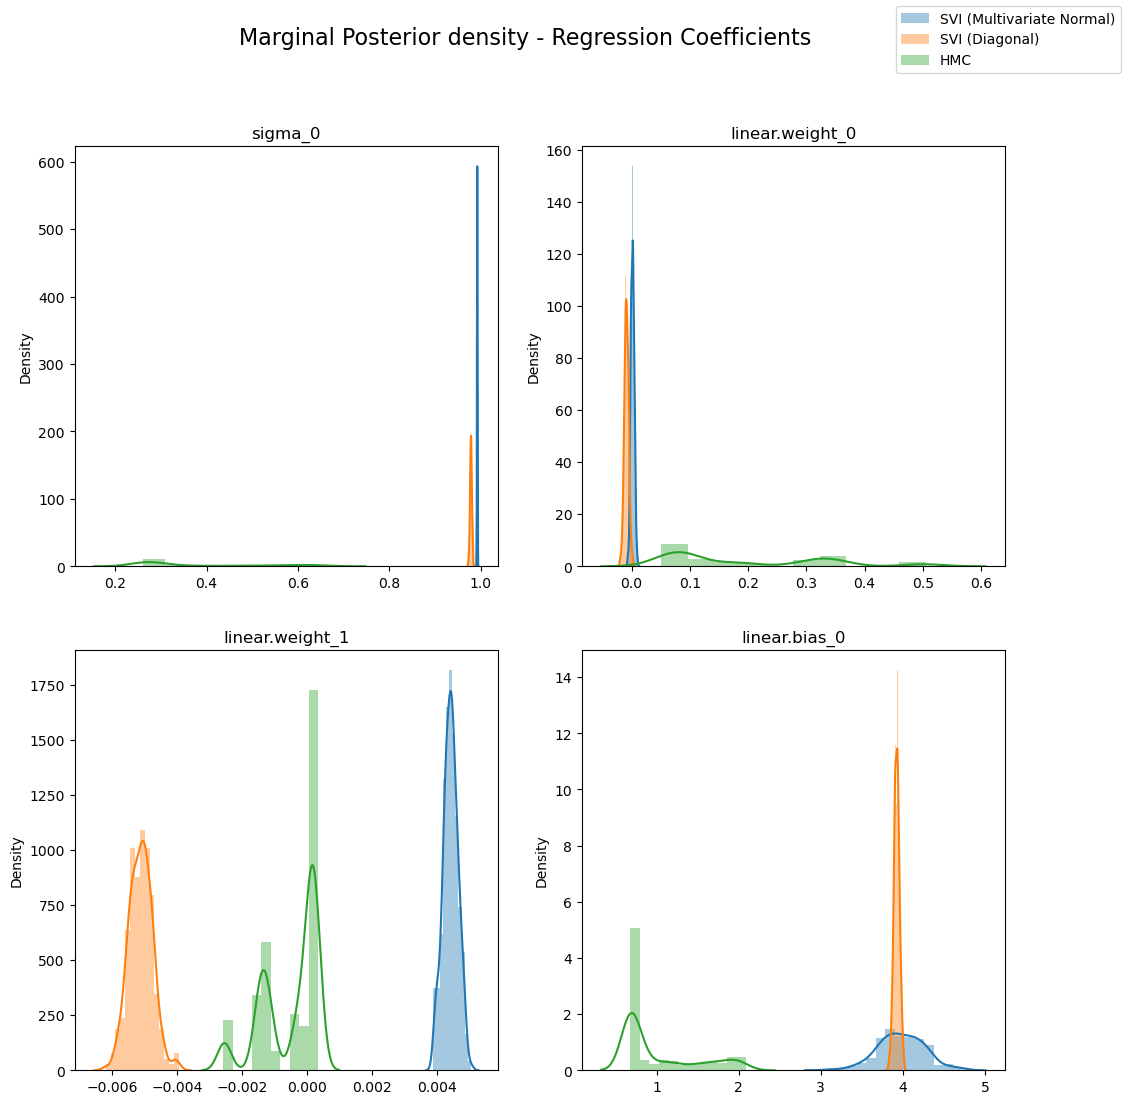

In [27]:
n_vars = X.shape[1]+2
fig, axs = plt.subplots(nrows=int(n_vars/2), ncols=2, figsize=(6*int(n_vars/2),12))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)

for i, ax in enumerate(axs.reshape(-1)):
    if i<len(param_mvn.columns):
        site = param_mvn.columns[i]
        sns.distplot(param_mvn[site], ax=ax, label="SVI (Multivariate Normal)")
        sns.distplot(param_diagonal[site], ax=ax, label="SVI (Diagonal)")
        sns.distplot(param_hmc[site], ax=ax, label="HMC")
        ax.set_xlabel("")
        ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

### Diagonal vs MVN

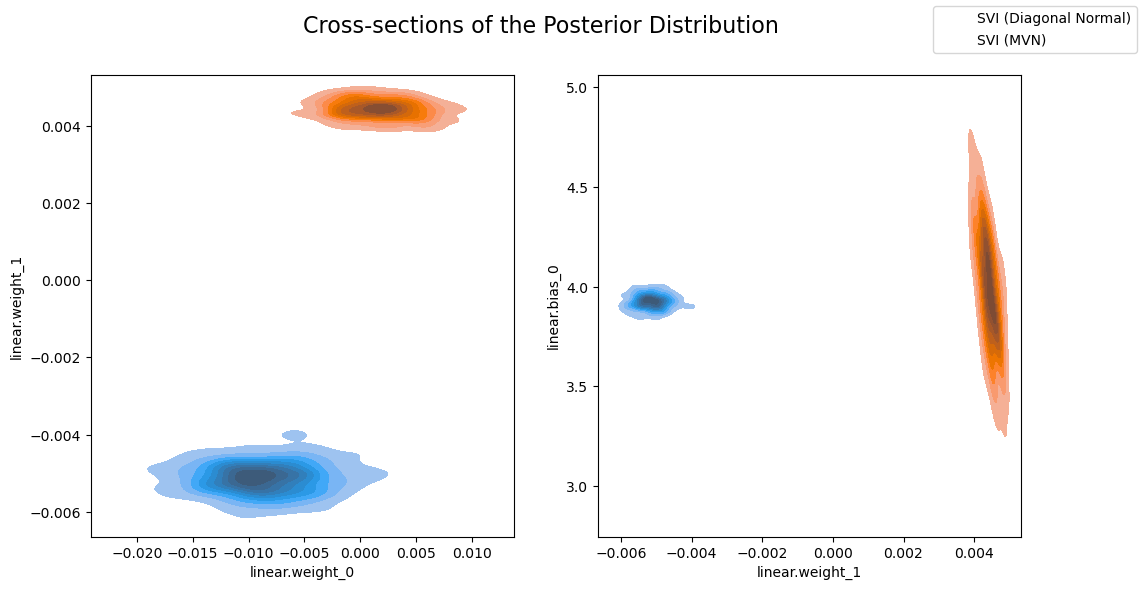

In [42]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)

sns.kdeplot(x=param_diagonal["linear.weight_0"], y=param_diagonal["linear.weight_1"], ax=axs[0],\
            label="SVI (Diagonal Normal)", fill=True)
sns.kdeplot(x=param_mvn["linear.weight_0"], y=param_mvn["linear.weight_1"], ax=axs[0],\
            label="SVI (MVN)", fill=True)
# sns.kdeplot(x=param_hmc["linear.weight_0"], y=param_hmc["linear.weight_1"], ax=axs[0],\
#             label="HMC", fill=True)
axs[0].set(xlabel="linear.weight_0", ylabel="linear.weight_1")


a=sns.kdeplot(x=param_diagonal["linear.weight_1"], y=param_diagonal["linear.bias_0"], ax=axs[1],\
            label="SVI (Diagonal Normal)", fill=True)
b=sns.kdeplot(x=param_mvn["linear.weight_1"], y=param_mvn["linear.bias_0"], ax=axs[1],\
            label="SVI (MVN)", fill=True)
# c=sns.kdeplot(x=param_hmc["linear.weight_1"], y=param_hmc["linear.bias_0"], ax=axs[1],\
#             label="HMC", fill=True)
axs[1].set(xlabel="linear.weight_1", ylabel="linear.bias_0")
# fig.legend()
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');